In [3]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

In [6]:
def d_depth_proj_ev(depth_and_seed_ops, size, Hamiltonian, temp, ts,
                    observables, visualize_H_evs, visualization_nonherm, visualize_expt_vals):
    
    ### building reference states and testing it
    start_time_1 = time.time()
    K_ref, rho_ref = me.build_reference_state(temp = temp_ref, 
                                              Hamiltonian = Hamiltonian,
                                              lagrange_op = cl_ops["n_oc_disp"], 
                                              lagrange_mult = .5)
    
    basis_incursive = me.vectorized_recursive_basis(depth_and_ops=depth_and_seed_ops,                                             
                                                    Hamiltonian=Hamiltonian, 
                                                    rho0=rho_ref)
    
    basis_orth = me.base_orth(ops = basis_incursive, 
                              rho0 = rho_ref, 
                              sc_prod = me.HS_inner_prod_r, 
                              visualization = False, reinforce_reality=False)
    
    print("using a base of size ", len(basis_orth))
    print("rho_ref: ", rho_ref)
    ### test 2
    
    me.basis_orthonormality_check(basis = basis_orth, 
                                  rho0 = rho_ref, 
                                  sc_prod = me.HS_inner_prod_r)
    
    ### constructing the initial state and H-tensor
    phi0, rho0 = me.build_rho0_from_basis(basis = basis_orth, temp=temp)
    Hijtensor = me.H_ij_matrix(Hamiltonian = Hamiltonian,
                               basis = basis_orth, 
                               rho0 = rho_ref, 
                               sc_prod = me.HS_inner_prod_r)
   
    ### constructing the coefficient arrays and the physical states
    res_proj_ev_rhot_list, phit = me.semigroup_phit_and_rhot_sol(phi0 = phi0, rho0 = rho0, 
                                                     Htensor = Hijtensor, ts = ts, basis = basis_orth)

    ### test 3
    herm_rhot_list = me.semigroup_rhos_test(rho_list = res_proj_ev_rhot_list, 
                                           visualization_nonherm = visualization_nonherm, ts = ts)
    
    ### Projected solution
    
    res_proj_ev = [np.array([qutip.expect(obs, rhot) for rhot in res_proj_ev_rhot_list]) for obs in observables]
    print("Proj ev runtime = ", time.time() - start_time_1)
    
    ### Exact solution 
    
    start_time_2 = time.time()
    res_exact = me.mesolve(Hamiltonian, rho0=rho0, tlist=ts, c_ops=None, e_ops=observables)
    
    print("Exact ev runtime = ", time.time() - start_time_2)
    
    if visualize_expt_vals:
        me.plot_exact_v_proj_ev_avgs(observables, label_ops, ts, res_proj_ev, res_exact)
        label_metric = ["Bures Exact v. Proj ev", "S(exact || proj_ev)", "S(proj_ev || exact)"]
        me.plot_exact_v_proj_ev_metrics(ts, res_proj_ev_rhot_list, res_exact, label_metric)
    
    return rho0, res_proj_ev_rhot_list, res_exact, res_proj_ev, basis_orth, phit

In [7]:
N=3; chain_type = "XYZ"; 

### Construcción de los operadores
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

#rho_tolerance = (-.5 * H_H).expm(); #rho_tolerance = rho_tolerance/rho_tolerance.tr()
#sigma_tolerance = (-.4 * H_H).expm(); #sigma_tolerance = sigma_tolerance/sigma_tolerance.tr()

### classical operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True]


## Base completa

In [13]:
k_B = 1; 
temp = 10.;           # Temperatura para el estado inicial
temp_ref=1000.;       # Temperatura para el estado de referencia
ts = np.linspace(0, 20,100)  # Tiempos a barrer

H_H_powers = [(1, H_H),(1, H_H*H_H),(1, H_H*H_H*H_H*H_H)]
    
depth_and_seed_ops_NG = [(1, cl_ops["identity_op"]),
                      (2, cl_ops["x_op"]),
                      (1, cl_ops["p_op"]),
                      (1, cl_ops["n_oc_op"]),
                      (1, cl_ops["n_oc_disp"]),                
                      (1, cl_ops["comm_xp"]),
                      (1, cl_ops["corr_xp"]),
                      (1, cl_ops["p_dot"]),
                      (1, cl_ops["x_op"]),
                      (4, cl_ops["magnetization"]),
                     ] + H_H_powers

observables = list(cl_ops.values())


using a base of size  15
rho_ref:  Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.125 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.125 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.125 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.125 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.124 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.124]]
The basis is orthonormal and hermitian


Proj ev runtime =  1.1790103912353516
Exact ev runtime =  0.021950483322143555


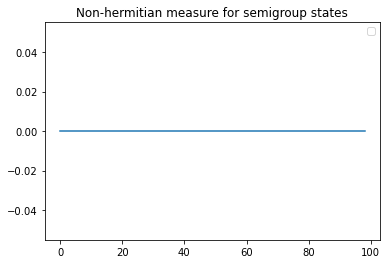

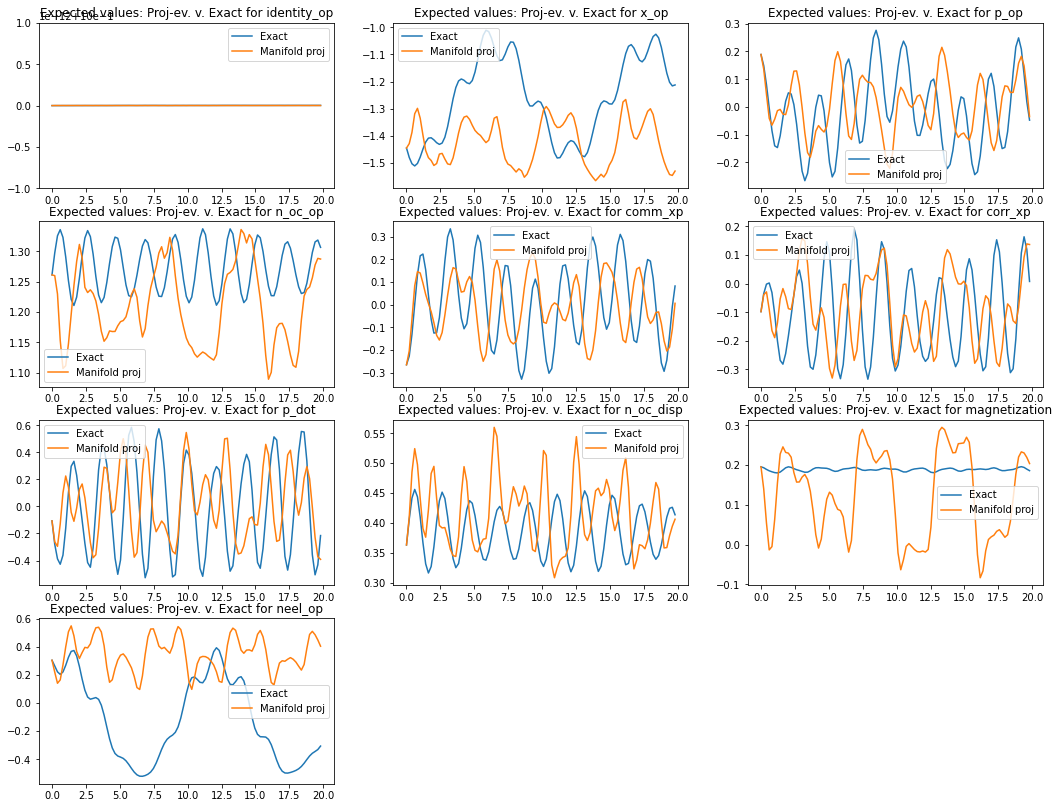

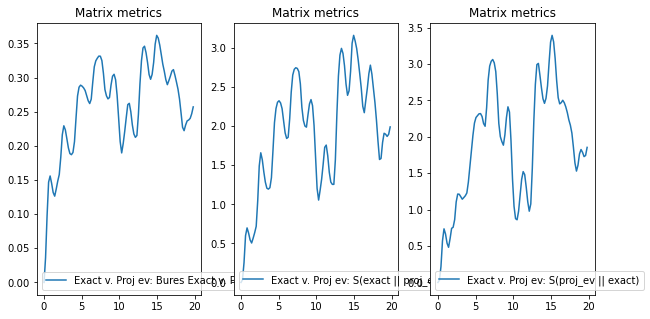

In [14]:
rho0, herm_rhot_list, res_exact, res_proj_ev, basis_orth, phit = d_depth_proj_ev(
    depth_and_seed_ops = depth_and_seed_ops_NG,
    size = N,
    Hamiltonian = H_H, 
    temp = 1., ts = ts,
    observables = observables, 
    visualize_H_evs = False, visualization_nonherm = True, visualize_expt_vals = True
)

Notar que la entropía del estado "exacto" no es constante, sino que crece, mientras que la del estado aproximado oscila. La amplitud de las oscilaciones parece depender de delta t. Al hacer el paso más pequeño, la fluctuación disminuye. Lo mismo ocurre con las distancias entre el estado exacto y el aproximado.

## Base superficial para x y p

using a base of size  6
rho_ref:  Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.125 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.125 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.125 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.125 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.124 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.124]]
The basis is orthonormal and hermitian


Proj ev runtime =  1.5903141498565674
Exact ev runtime =  0.1039884090423584


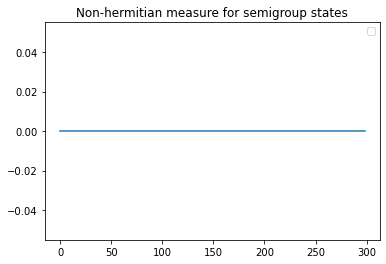

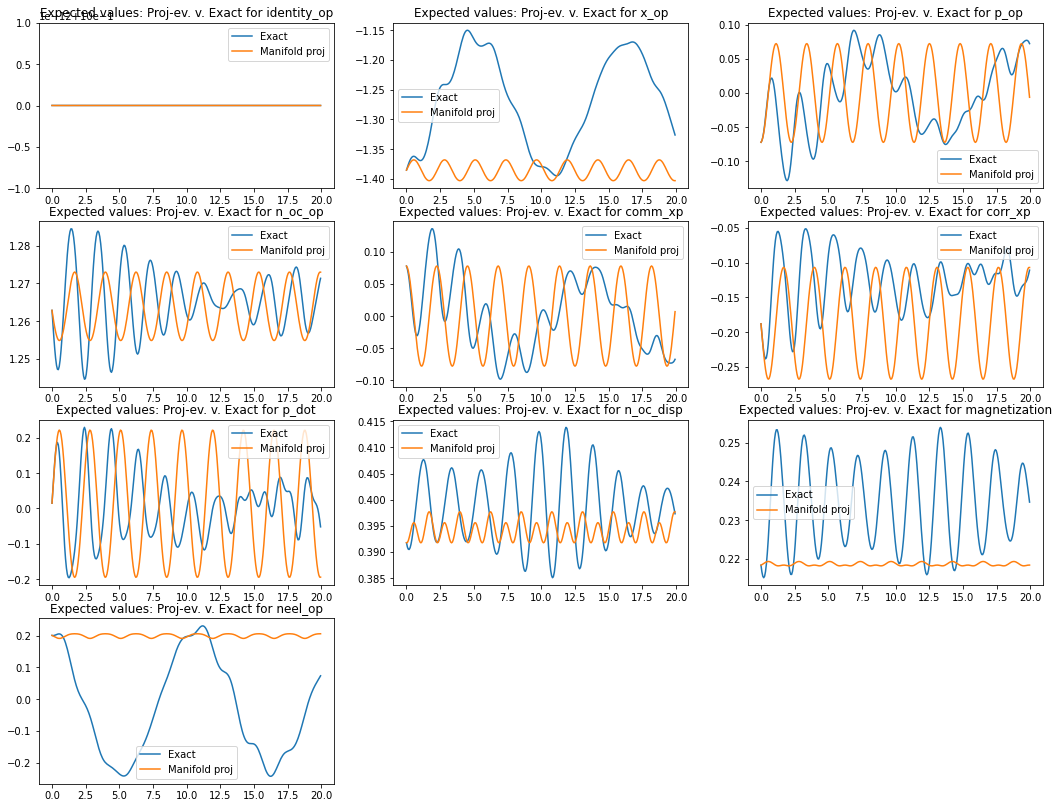

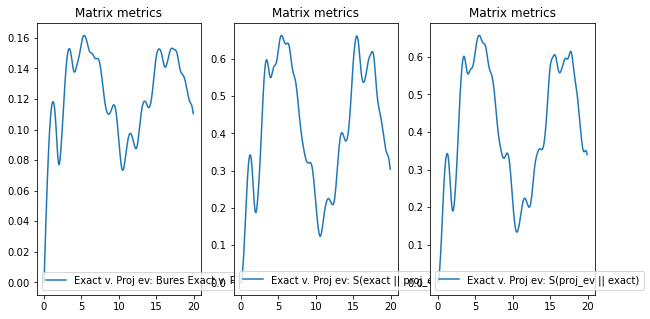

In [16]:
N = 2; k_B = 1; 
temp = 10.;           # Temperatura para el estado inicial
temp_ref=1000.;       # Temperatura para el estado de referencia
ts = np.linspace(0, 20,300)  # Tiempos a barrer


depth_and_seed_ops = [(1, cl_ops["identity_op"]),
                      (1, cl_ops["x_op"]),
                      (1, cl_ops["p_op"]),
                      (1, H_H),
                      # (1, cl_ops["n_oc_op"]),
                      #(1, cl_ops["n_oc_disp"]),
                      # (1, cl_ops["comm_xp"]),
                      (1, cl_ops["corr_xp"]),
                      (1, cl_ops["p_dot"]),
                      (1, cl_ops["x_op"]),
                     ]

rho0, herm_rhot_list, res_exact, res_proj_ev, basis_orth, phit = d_depth_proj_ev(
    depth_and_seed_ops = depth_and_seed_ops,
    size = N,
    Hamiltonian = H_H, 
    temp = 1., ts = ts,
    observables = observables, 
    visualize_H_evs = False, visualization_nonherm = True, visualize_expt_vals = True
)

En este caso, al no trabajar con la base completa, el observable de magnetización (la ocupación) se empieza a correr respecto al exacto. Las frecuencias de oscilación se mantienen practicamente iguales que en el caso exacto.

using a base of size  15
rho_ref:  Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.125 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.125 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.125 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.125 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.124 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.124]]
The basis is orthonormal and hermitian


Proj ev runtime =  3.8344924449920654
Exact ev runtime =  0.042926788330078125


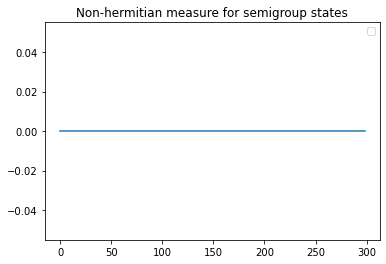

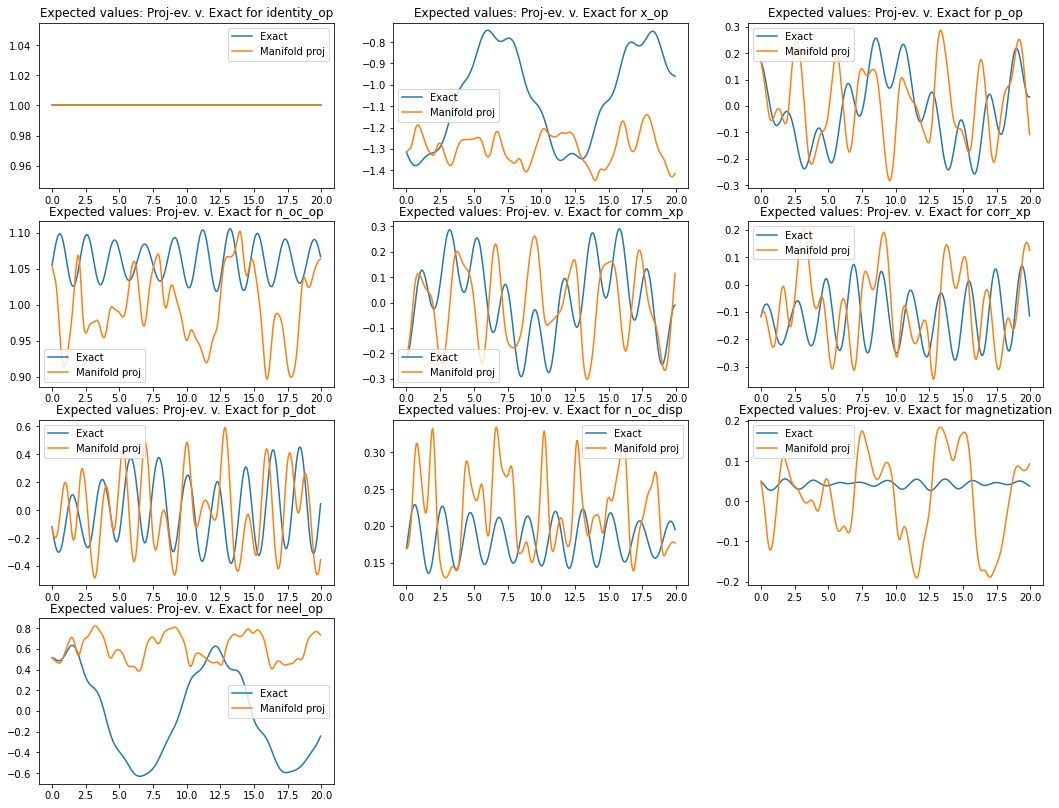

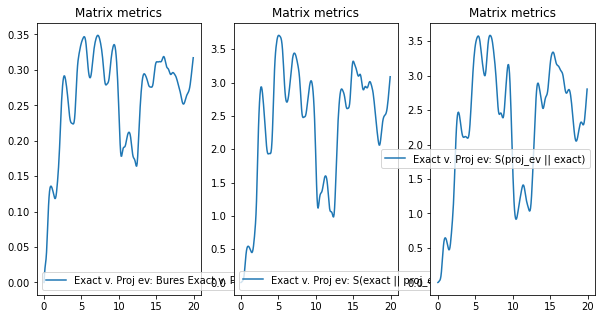

In [20]:
N = 2; k_B = 1; 
temp = 10.;           # Temperatura para el estado inicial
temp_ref=1000.;       # Temperatura para el estado de referencia
ts = np.linspace(0, 20,300)  # Tiempos a barrer


depth_and_seed_ops = [(1, cl_ops["identity_op"]),
                      (3, cl_ops["x_op"]),
                      (1, cl_ops["p_op"]),
                      (1, H_H),
                      (1, cl_ops["corr_xp"]),
                      (1, cl_ops["p_dot"]),
                      (5, cl_ops["magnetization"]),
                      (2, cl_ops["neel_op"])
                     ]
rho0, herm_rhot_list, res_exact, res_proj_ev, basis_orth, phit = d_depth_proj_ev(
    depth_and_seed_ops = depth_and_seed_ops_NG,
    size = N,
    Hamiltonian = H_H, 
    temp = 1., ts = ts,
    observables = observables, 
    visualize_H_evs = False, visualization_nonherm = True, visualize_expt_vals = True
)